# Signal analysis
In this notebook, we will look at signal processing of discrete signals, similar to those in [Banks et. al](https://doi.org/10.1109/AERO.2004.1368169).

However, we start by looking at how to analyze signals. We start by generating a simple signal consisting of two sinusoidal frequencies, with different amplitudes and phases

In [183]:
import numpy as np
T = 3 # Runtime of simulation (s)
sampling_rate = 45 # Hz (1/s)
ts = np.linspace(0, T, int(T*sampling_rate), endpoint=False) # Sample points

In [184]:
def single_signal(A, f, phase, t):
    return A * np.cos(2*np.pi*f*t + phase)

amplitudes = np.array([2.1, 1.3], dtype=np.float64)
frequencies = np.array([3., 7.], dtype=np.float64)
phases = np.array([63/180*np.pi, 45/180*np.pi], dtype=np.float64)
signal = sum([single_signal(A, f, phase, ts) for (A, f, phase) in zip(amplitudes,frequencies, phases)])


We start by computing

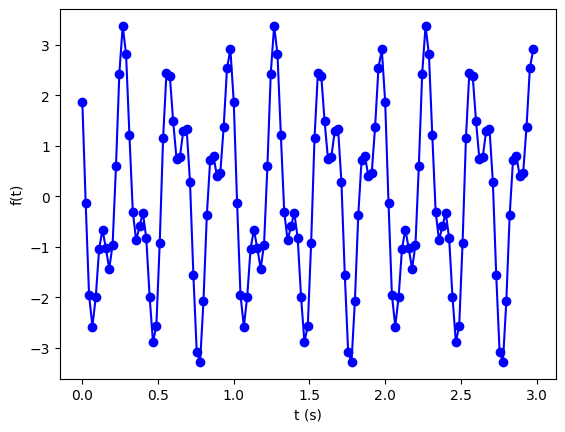

In [185]:
import matplotlib.pyplot as plt
plt.plot(ts, signal, "-bo")
plt.xlabel("t (s)")
plt.ylabel("f(t)")
plt.show()

# Discrete Fourier transform
The discrete Fourier transform (DFT) takes in a signal from the time-domain and transform it into the frequency domain.
Given samples $(t_n, x_n), n=0,\dots,N-1$, we can write the signal as

$$
\begin{align}
    \hat x_k =\sum_{n=0}^{N-1}x_n\cdot e^{-i2\pi k n/N}
\end{align}
$$
where the amplitude of the signal is equal to  $\frac{\vert \hat x_k\vert}{N}$, and the phase
$\mathrm{atan2}(\mathrm{Im}(\hat x_k), \mathrm{Re}(\hat x_k))$
which means that we can recover a signal from the DFT by computing the inverse transform
$$
\begin{align}
    x_k = \frac{1}{N}\sum_
    {j=0}^{N-1} \hat x_j e^{i 2\pi j k/N}
\end{align}
$$
We can compute the DFT as a matrix-vector product (with $\mathcal{O}(N^2)$ operations)

In [186]:
def DFT(f: np.ndarray)->np.ndarray:
    """
    Compute the discrete Fourier transform of input signal f
    """
    N = len(f)
    n = np.arange(N, dtype=np.float64)
    k = n.reshape(N, 1)
    exponential = np.exp(-2j*np.pi*k*n/N)
    return np.dot(exponential, f)

def iDFT(frequencies: np.ndarray) ->np.ndarray:
    """
    Compute the inverse Discrete Fourier transform
    """
    N = len(frequencies)
    n = np.arange(N, dtype=np.float64)
    k = n.reshape(N, 1)
    exponential = np.exp(2j*np.pi*k*n/N)
    return 1./N*np.dot(exponential, frequencies)

We compute the DFT of our signal and get the following amplitude plot

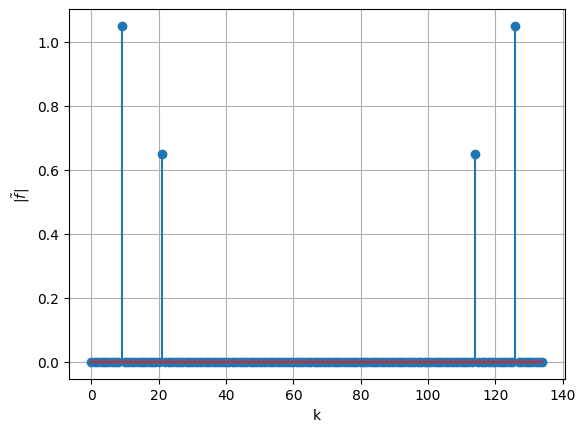

In [187]:
fft_frequencies = DFT(signal)
amplitudes = np.abs(fft_frequencies)/len(signal)
plt.figure()
plt.stem(np.arange(len(fft_frequencies)), amplitudes, label="Amplitude")
plt.xlabel("k")
plt.ylabel(r"$\vert \tilde f \vert$")
plt.grid()
plt.show()

We observe four frequencies corresponding to the frequency $2\pi f/N$, the positive and negative values of $\sin(\omega t)=\frac{1}{2j}(e^{i\omega t}-e^{-i\omega t})$

In [188]:
tol = 1e-6
positions = np.flatnonzero(amplitudes>tol)
print(f"Frequencies {positions}")
print(f"Frequencies/T {positions/T}")
print(f"Amplitudes {amplitudes[positions]}")
print(f"Angles {np.angle(fft_frequencies[positions])*180/np.pi}")

Frequencies [  9  21 114 126]
Frequencies/T [ 3.  7. 38. 42.]
Amplitudes [1.05 0.65 0.65 1.05]
Angles [ 63.  45. -45. -63.]


We also compute the phase shifts

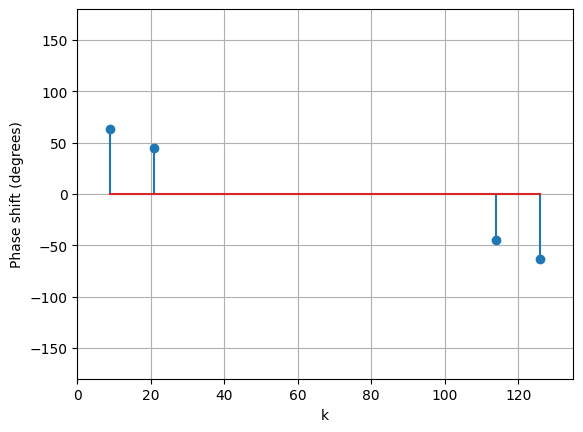

In [189]:
phases = np.angle(fft_frequencies[positions])
plt.stem(positions, phases*180/np.pi)
plt.axis([0,len(ts), -180, 180])
plt.ylabel("Phase shift (degrees)")
plt.xlabel("k")
plt.grid()
plt.show()

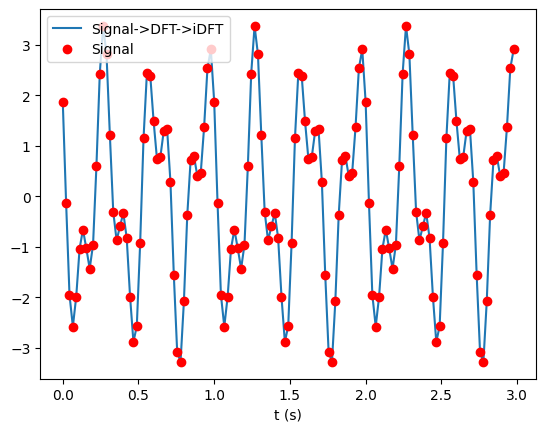

In [190]:
recovered_signal = iDFT(fft_frequencies)
plt.plot(ts, np.real(recovered_signal), label="Signal->DFT->iDFT")
plt.plot(ts, signal, "ro", label="Signal")
plt.xlabel("t (s)")
plt.legend()
plt.show()

## Noisy data
Let us add some noise to the previous signal, we add noise with as standard normal distribution with mean=0, variance=1

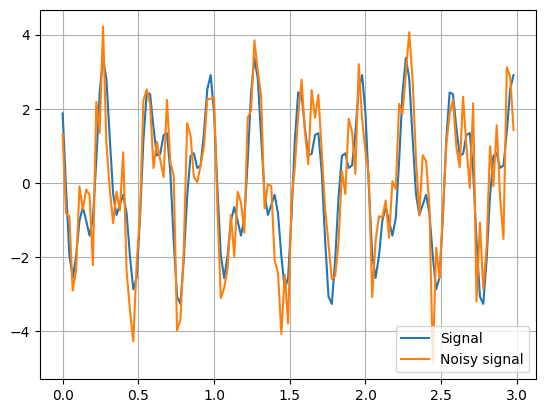

In [191]:
noisy_signal = signal + np.random.randn(len(signal))
plt.figure()
plt.plot(ts, signal, label="Signal")
plt.plot(ts, noisy_signal, label="Noisy signal")
plt.grid()
plt.legend()
plt.show()

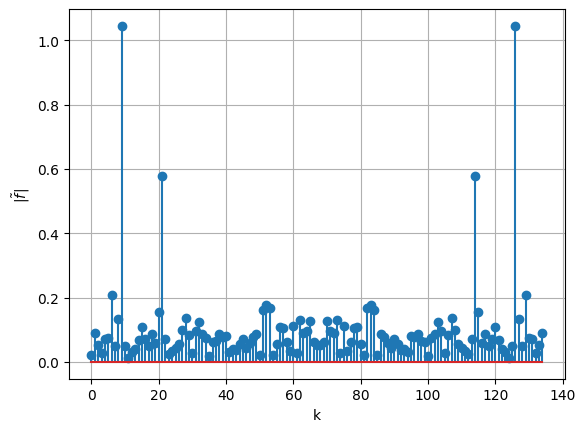

In [192]:
fft_noisy = DFT(noisy_signal)
amp_noisy = np.abs(fft_noisy)/len(signal)
plt.figure()
plt.stem(np.arange(len(fft_noisy)), amp_noisy, label="Amplitude")
plt.xlabel("k")
plt.ylabel(r"$\vert \tilde f \vert$")
plt.grid()
plt.show()

We now can filter out all the lower frequencies. We do this by finding the sorting order of the amplitudes, and only choose the top 6 amplitudes

In [193]:
frequency_order = np.argsort(amp_noisy)
num_amplitudes = 6
top_amplitudes = frequency_order[-num_amplitudes:]
print(f"Largest frequencies {top_amplitudes}")
print(f"Amplitudes {amp_noisy[top_amplitudes]}")
print(f"Angles: {np.angle(fft_noisy[top_amplitudes])*180/np.pi}")

Largest frequencies [  6 129 114  21   9 126]
Amplitudes [0.20850941 0.20850941 0.57886575 0.57886575 1.04427583 1.04427583]
Angles: [-161.57752691  161.57752691  -55.83746474   55.83746474   63.07950682
  -63.07950682]


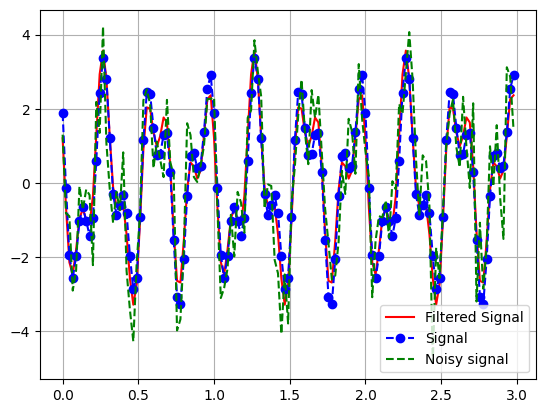

In [194]:
filtered_frequencies = np.zeros(len(fft_frequencies), dtype=np.complex128)
filtered_frequencies[top_amplitudes] = fft_noisy[top_amplitudes]
filtered_signal = iDFT(filtered_frequencies).real
fig = plt.figure()
plt.plot(ts, filtered_signal, "-r", label="Filtered Signal")
plt.plot(ts, signal, "--bo", label="Signal")
plt.plot(ts, noisy_signal, "g--", label="Noisy signal")
plt.grid()
plt.legend()
plt.show()

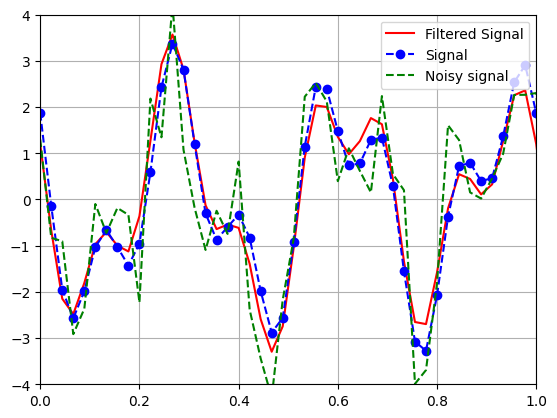

In [195]:
fig.axes[0].axis([0,1,-4,4])
import IPython 
IPython.display.display(fig)

# Software packages delivering Fourier transforms
As the discrete Fourier transform is known as a slow algorithm ($\mathcal{O}(N^2)$ operations), we instead want to use the [Fast Fourier transformation](https://doi.org/10.2307/2003354) which have been implemented efficiently in many Python-libraries, such as
[numpy](https://numpy.org/doc/stable/reference/routines.fft.html), [scipy](https://docs.scipy.org/doc/scipy/tutorial/fft.html) and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/signal/fft)

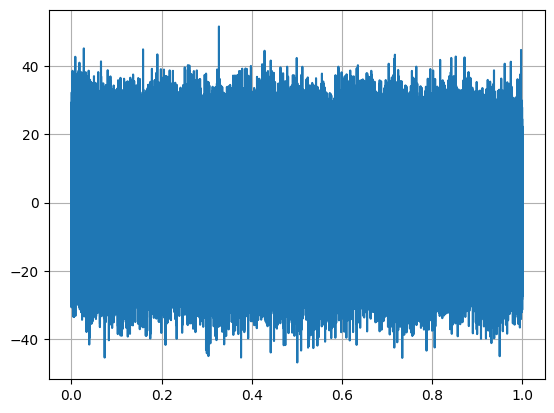

In [196]:
T = 1 # (s) Simulation time from banks paper
sampling_rate = 102.4e4 # (hz) Sampling rate from Banks paper
t = np.linspace(0, T, int(T*sampling_rate), endpoint=False)
frequency = 5
phase = 27*np.pi/180.
signal = np.sin(2*np.pi*frequency*t+phase) + 10*np.random.randn(len(t))
fig = plt.figure()
plt.plot(t, signal)
plt.grid()
plt.show()

Got a memory error, message follows: Unable to allocate 15.3 TiB for an array with shape (1024000, 1024000) and data type complex128
Numpy FFT: 0.06100257200159831 s


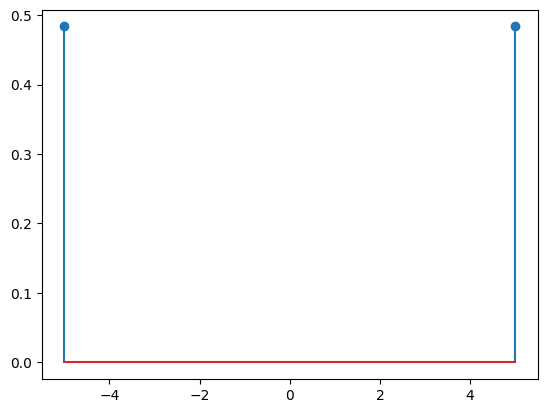

In [197]:
import time
try:
    start = time.perf_counter()
    fft = DFT(signal)
    end = time.perf_counter()
    print(f"DFT: {end-start} s")
except MemoryError as e:
    print(f"Got a memory error, message follows: {e}")

start_np = time.perf_counter()
fft_np = np.fft.fft(signal)
end_np = time.perf_counter()
print(f"Numpy FFT: {end_np-start_np} s")
freq = np.fft.fftfreq(len(fft_np), d=1/sampling_rate)
shift_freq = np.fft.fftshift(freq)
shift_mag = np.fft.fftshift(np.abs(fft_np))
filter_vals = np.argwhere(shift_mag>0.25*np.max(shift_mag))
plt.stem(shift_freq[filter_vals], shift_mag[filter_vals]/len(freq))
plt.show()

# Spectral density
In the Banks-paper, they compute the Power spectrum  density (PSD) of the signal. You can estimate the PSD by the DFT as the square magnitude of the DFT

$$E=\int_{-\infty}^\infty \vert x(t) \vert^2~\mathrm{d}t$$

which we can write for each frequency as 

$$\bar S_{xx}(f) = \vert\hat x(f)\vert^2$$

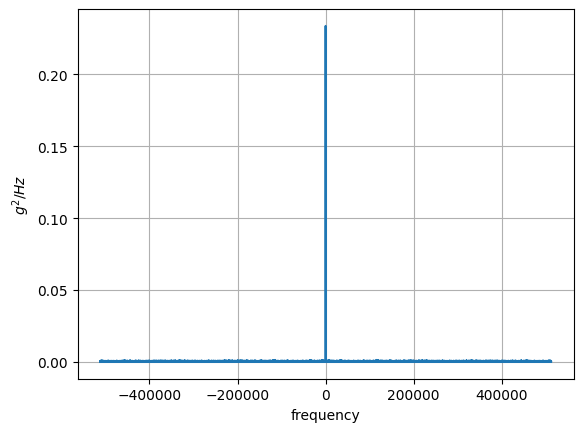

In [198]:
Sxx = (shift_mag/len(fft_np))**2
plt.plot(shift_freq, Sxx)
plt.ylabel(r"$g^2/Hz$")
plt.xlabel("frequency")
plt.grid()
plt.show()

We can also compute `PSD` of a signal directly with `matplotlib`.
Observe that the y-axis is on the desibel scale. 

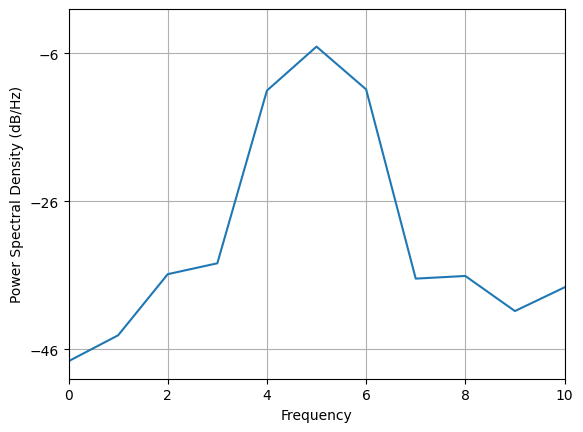

In [199]:
pxx, freqs = plt.psd(signal, Fs=sampling_rate, sides="onesided", NFFT=int(sampling_rate))
plt.axis([0,10,-50, 0])
plt.show()

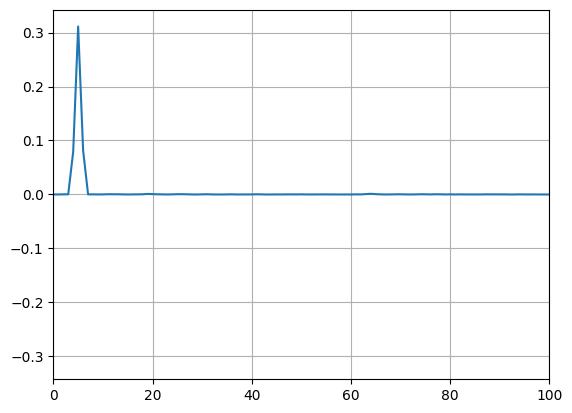

In [202]:
plt.plot(freqs, pxx)
plt.axis([0,100, -1.1*abs(max(pxx)),1.1*abs(max(pxx))])
plt.grid()